# SWDB - Day 2, Tutorial 1

## Population-Level Decoding: Part 1

In this tutorial, we will introduce the Allen Brain Observatory Neuropixels dataset, and use it to extract information about stimulus identity from neural populations. We will focus on activity in V1 (Allen CCF acronym: `VISp`) and drifting gratings stimuli, but the methods will generalize to other areas and stimulus types.

We start by importing the packages we'll need.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

import warnings
warnings.filterwarnings("ignore")

We will access the data via the AllenSDK. It's a good idea to first check which version you have installed, in case some of the functions are not working properly:

In [2]:
import allensdk

allensdk.__version__

'2.15.1'

### Exploring the Neuropixels Visual Coding dataset

The Allen Brain Observatory Neuropixels Visual Coding dataset consists of 58 passive viewing sessions that use many of the same stimuli as the 2P Visual Coding experiments we learned about yesterday. Instead of using 2P imaging to monitor calcium-dependent fluorescence signals, these experiments use acutely implanted Neuropixels probes to record spiking activity. This makes it possible to sample neural activity with 1000x higher temporal resolution across multiple cortical and subcortical regions in parallel. However, unlike with 2P imaging, it is impossible to return to the same neurons across multiple sessions or easily record from genetically defined sub-populations.

The data is made accessible via an `EcephysProjectCache` object. If you're analyzing data on a local machine, this object will keep track of which files you have downloaded, and retrieve additional files as needed. In this case, we're doing our analysis in the cloud, and the public S3 bucket containing all of the data files is already mounted. So we just need to make sure the `EcephysProjectCache` object is aware of the location where the data is stored:

In [3]:
manifest_path = '/data/allen-brain-observatory/visual-coding-neuropixels/ecephys-cache/manifest.json' 

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

We can use the `cache` object to retrieve a table containing information about all of the experimental sessions:

In [4]:
sessions = cache.get_session_table()

sessions.head()

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
721123822,2019-10-03T00:00:00Z,707296982,brain_observatory_1.1,125.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,444,2229,6,"[MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ..."
732592105,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt,824,1847,5,"[grey, VISpm, nan, VISp, VISl, VISal, VISrl]"
737581020,2019-10-03T00:00:00Z,718643567,brain_observatory_1.1,108.0,M,wt/wt,568,2218,6,"[grey, VISmma, nan, VISpm, VISp, VISl, VISrl]"


We can examine at a single row to see what information is available about each session:

In [5]:
sessions.iloc[0]

published_at                                               2019-10-03T00:00:00Z
specimen_id                                                           699733581
session_type                                              brain_observatory_1.1
age_in_days                                                               118.0
sex                                                                           M
full_genotype                     Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
unit_count                                                                  884
channel_count                                                              2219
probe_count                                                                   6
ecephys_structure_acronyms    [CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ...
Name: 715093703, dtype: object

We have information about the subject (e.g. age, sex, genotype), as well as the total number of units recorded, and a list of structures they were recorded from. We use the term "units" instead of "neurons" because each unit may actually include spikes from multiple nearby neurons. The units that are returned by default are pre-filtered to remove those with high levels of contamination (based on the `isi_violations` metric), but they are  not guaranteed to all correspond to perfectly isolated neurons.

One of the most important things to consider about each session is the `session_type`, of which there are two in the Neuropixels Visual Coding dataset:

In [6]:
sessions.session_type.unique()

array(['brain_observatory_1.1', 'functional_connectivity'], dtype=object)

The two session types differ in the visual stimuli that were used. `brain_observatory_1.1` sessions include many of the same stimuli that were shown in the 2P Visual Coding experiments, to facilitate direct comparisons between these two data modalities. `functional_connectivity` sessions use similar stimuli but with fewer conditions and more repeats, to facilitate analysis of cross-area interactions. 

A timeline of each session type is available in the Neuropixels Cheat Sheet PDF, and is also reproduced here:

![Diagram of stimuli for each session type](neuropixels_visual_stimuli.png)

For this tutorial, we are going to use the "Brain Observatory 1.1" sessions, which include the identical drifting grating stimulus as the 2P experiments.

In order to select the specific session we want to analyze, we can examine some pre-computed unit metrics:

In [7]:
unit_metrics = cache.get_unit_analysis_metrics_by_session_type('brain_observatory_1.1')

dg_metrics = [k for k in unit_metrics.keys() if 'dg' in k]
dg_metrics

['c50_dg',
 'fano_dg',
 'f1_f0_dg',
 'g_dsi_dg',
 'g_osi_dg',
 'mod_idx_dg',
 'pref_tf_dg',
 'run_mod_dg',
 'pref_ori_dg',
 'run_pval_dg',
 'firing_rate_dg',
 'pref_tf_multi_dg',
 'pref_ori_multi_dg',
 'lifetime_sparseness_dg']

There are 14 different metrics for the drifting gratings (`dg`) stimulus type, which have been computed for all units in this dataset. Let's use the `g_dsi_dg` metric to find sessions with a high number of units in V1 that are selective for grating direction.

First, we need to find the IDs for all of the relevant sessions:

In [8]:
unique_sessions = unit_metrics.ecephys_session_id.unique()
unique_sessions

array([732592105, 721123822, 715093703, 763673393, 719161530, 742951821,
       743475441, 791319847, 797828357, 799864342, 798911424, 759883607,
       754829445, 744228101, 760693773, 773418906, 754312389, 739448407,
       757216464, 756029989, 750332458, 757970808, 760345702, 755434585,
       762602078, 750749662, 737581020, 762120172, 751348571, 746083955,
       761418226, 758798717])

Each session has a 9-digit ID that serves as a unique identifier. We can use these to loop through all of the sessions and plot the distribution of `g_dsi_dg` for all units in V1:

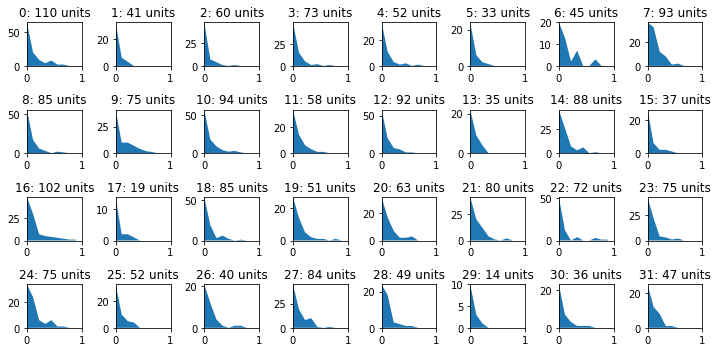

In [9]:
plt.figure(figsize=(10,5))

for session_index, ecephys_session_id in enumerate(unique_sessions):
    
    sub_df = unit_metrics[(unit_metrics.ecephys_session_id == ecephys_session_id) &
                          (unit_metrics.ecephys_structure_acronym == 'VISp')]
    
    h, b = np.histogram(sub_df.g_dsi_dg, bins=np.linspace(0,1,10))
    
    plt.subplot(4,8,session_index + 1)
    plt.fill_between(b[:-1],h)
    plt.title(f'{session_index}: {len(sub_df)} units')
    plt.xlim([0,1])
    plt.ylim([0, np.max(h)])
    
plt.tight_layout()

Let's analyze session 10, which has a relatively high number of V1 units, some fraction of which display direction selectivity above 0.5. We can load the data for this session based on the unique session ID:

In [10]:
session_id = unique_sessions[10]

session = cache.get_session_data(session_id)

### Loading data for one session

The `session` object will serve as the interface to all of the data for this experiment, including the spike times, stimulus info, and behavioral data (e.g. running speed).

First, we'll load a table of units for this session. Note that this step can sometimes be slow, since all of the spike times need to be loaded into memory.

In [11]:
units = session.units # can be slow -- needs to load all spike times

units.head()

,waveform_PT_ratio,waveform_amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_violations,isolation_distance,L_ratio,...,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
951088679,0.620607,82.147455,0.023654,1,480.97,2.575648,7.429131,0.053350,51.364291,0.028062,...,215.0,APN,8328,3018,7095,probeA,See electrode locations,29999.965974,1249.998582,True
951088664,0.587044,78.399165,0.001739,0,427.07,3.085334,6.843864,0.033732,40.358293,0.051513,...,215.0,APN,8328,3018,7095,probeA,See electrode locations,29999.965974,1249.998582,True
951088734,0.560996,187.504005,0.001249,5,311.01,5.152564,1.418476,0.356931,56.950961,0.001292,...,215.0,APN,8316,2988,7099,probeA,See electrode locations,29999.965974,1249.998582,True
951088721,0.474457,196.741545,0.000059,4,355.17,4.295014,11.517381,0.000271,58.358552,0.020218,...,215.0,APN,8316,2988,7099,probeA,See electrode locations,29999.965974,1249.998582,True
951088862,0.534674,92.125020,0.089901,16,239.50,4.043348,19.953126,0.013619,79.934237,0.011335,...,215.0,APN,8304,2958,7103,probeA,See electrode locations,29999.965974,1249.998582,True


Next, we'll load a table of containing information about all of the stimuli that were shown:

In [12]:
from allensdk.brain_observatory.ecephys.stimulus_table import naming_utilities
naming_utilities.standardize_movie_numbers = lambda a : a
session.naming_utilities = naming_utilities # this is a hack needed to circumvent a bug in the AllenSDK

stimulus_presentations = session.stimulus_presentations

stimulus_presentations.head()

,color,contrast,frame,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,x_position,y_position,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
0,null,null,null,null,null,null,null,24.875987,null,spontaneous,84.942787,null,null,null,60.066800,0
1,null,0.8,null,90.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,84.942787,0.0,gabors,85.176306,4.0,20.0,-10.0,0.233519,1
2,null,0.8,null,0.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,85.176306,0.0,gabors,85.426505,4.0,30.0,40.0,0.250199,2
3,null,0.8,null,45.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,85.426505,0.0,gabors,85.676704,4.0,40.0,-30.0,0.250199,3
4,null,0.8,null,90.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,85.676704,0.0,gabors,85.926904,4.0,0.0,-40.0,0.250199,4


`stimulus_presentations` is a `DataFrame` containing one row for each presentation or "trial." We can see all of the types of stimuli by looking for the unique stimulus names in this table:

In [13]:
stimulus_presentations.stimulus_name.unique()

array(['spontaneous', 'gabors', 'flashes', 'drifting_gratings',
       'natural_movie_three', 'natural_movie_one', 'static_gratings',
       'natural_scenes', 'drifting_gratings_contrast'], dtype=object)

### Plotting the response to drifting gratings

Let's create smaller tables containing only the `drifting_gratings` stimuli, and just the units in V1: 

In [14]:
stimulus_presentations_dg = stimulus_presentations[stimulus_presentations.stimulus_name == 'drifting_gratings']

units_VISp = units[units.ecephys_structure_acronym == 'VISp']

unit_metrics_VISp = unit_metrics.loc[units_VISp.index.values]

To explore some example drifting grating responses with spikes, we'll select the unit with the highest direction selectivity. When describing gratings stimuli, "direction" refers to the *angle of motion*, which varies between 0 and 360 degrees, while "orientation" refers to the *angle of the grating on individual frames*, which varies between 0 and 180 degrees.

In [15]:
unit_id = unit_metrics_VISp.g_dsi_dg.idxmax()

unit_metrics_VISp.loc[unit_id].g_dsi_dg

0.6677837744443985

Let's plot this unit's response to all of the different drifting gratings stimulus conditions. Note that the stimulus presentations table only contains one column to describe the grating angle, which is called `orientation`:

In [16]:
orientations = np.sort(stimulus_presentations_dg.orientation.unique()[:-1].astype('float')) # remove the 'null value at the end'
temporal_frequencies = np.sort(stimulus_presentations_dg.temporal_frequency.unique()[:-1].astype('float')) # remove the 'null' value at the end

print(np.sort(orientations))
print(np.sort(temporal_frequencies))

[  0.  45.  90. 135. 180. 225. 270. 315.]
[ 1.  2.  4.  8. 15.]


We can make a raster plot for all presentations of each condition, with each dot representing one spike. The `presentationwise_spike_times` method makes it each to extract the spike times for one or more units, given a set of unique presentation IDs (contained in the index column of the `stimulus_presentations` table).

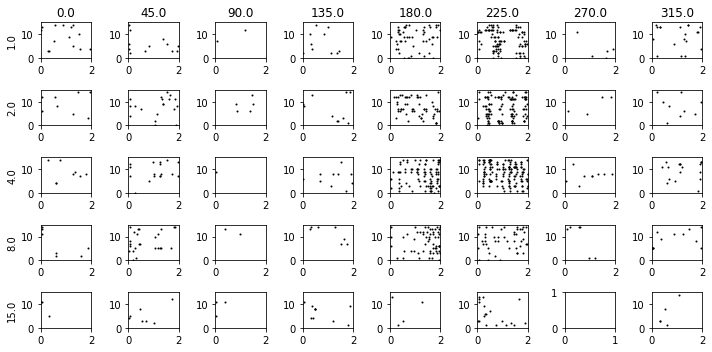

In [17]:
plt.figure(figsize=(10,5))

for tf_index, tf in enumerate(temporal_frequencies):
    
    for ori_idx, ori in enumerate(orientations):
        
        presentation_ids = stimulus_presentations_dg[
            (stimulus_presentations_dg.temporal_frequency == tf) &
            (stimulus_presentations_dg.orientation == ori)].index.values
        
        df = session.presentationwise_spike_times(presentation_ids, [unit_id])
        
        plt.subplot(len(temporal_frequencies),
                    len(orientations), 
                    ori_idx + tf_index * len(orientations) + 1)
        
        if tf_index == 0:
            plt.title(ori)
            
        if ori_idx == 0:
            plt.ylabel(tf)
        
        if len(df) > 0:
            df['trial_index'] = presentation_ids.searchsorted(df.stimulus_presentation_id.values)
            plt.scatter(df['time_since_stimulus_presentation_onset'], df['trial_index'], s=1, c='k')
            plt.xlim([0, 2]) # each trial is 2 seconds long
            plt.ylim([0,len(presentation_ids)])
            
plt.tight_layout()

We can very clearly see this unit's preferred orientation is 225 degrees, and it tends to fire more at lower temporal frequencies.

These raster plots display rich information about a unit's dynamics within a trial. For example, you can see that this unit tends to lock it's firing to a specific phase of the drifting grating at its preferred orientation, which is common for cells in V1.

However, for the purposes of population decoding, we are going to summarize the response to each presentation as a single number, the "firing rate." We can visualize the relative firing rate for each stimulus condition using a "star" plot:

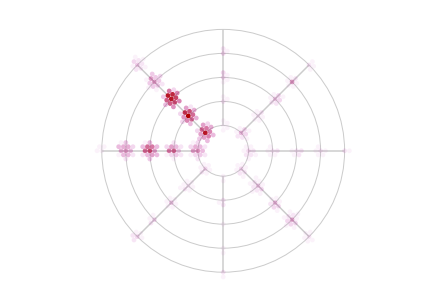

In [18]:
from allensdk.brain_observatory.ecephys.stimulus_analysis.drifting_gratings import DriftingGratings 
dg = DriftingGratings(session)
dg.make_star_plot(unit_id)

Each presentation is summarized as relative color intensity that's proportional to the firing rate. This is the information we will use for population-level decoding.

Note that this approach rests on two very important assumptions:
1. The decoder knows when the stimulus starts and ends
2. All spikes within this window are weighted equally

These are almost certainly not valid when thinking about how downstream brain regions actually decode activity, but they are very useful for understanding what type of information is represented in whatever brain region we're analyzing.

To compute this unit's firing rate for each presentation at a particular temporal frequency (2 Hz), we'll use a different helper method called `presentationwise_spike_counts`. This one is similar to `presentationwise_spike_counts`, except it returns the data as an `xarray.DataArray` with dimensions of `stimulus_presentation_id`, `time_relative_to_stimulus_onset`, and `unit_id`. This format makes it easy to sub-select data for different units, presentations, or time points within a trial.

In [19]:
presentations = stimulus_presentations_dg[
            (stimulus_presentations_dg.temporal_frequency == 2.0)]

presentations = presentations.sort_values(by='orientation')
        
da = session.presentationwise_spike_counts(np.arange(0,1.99,0.01), presentations.index.values, [unit_id])

da

<xarray.DataArray 'spike_counts' (stimulus_presentation_id: 120,
                                  time_relative_to_stimulus_onset: 198,
                                  unit_id: 1)>
array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
...
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]], dtype=uint16)
Coordinates:
  * stimulus_presentation_id         (stimulus_presentation_id) int64 3918 .....
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 ...
  * unit_id                          (unit_id) int64 951103589

To compute the firing rates, we just need to count spikes by summing across the time dimension, and then divide by two (the total number of seconds in each trial):

(0.0, 10.0)

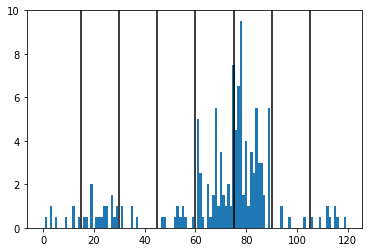

In [20]:
firing_rates = np.squeeze(da.sum('time_relative_to_stimulus_onset')) / 2

plt.bar(np.arange(len(presentations)), firing_rates, width=1)

plt.vlines(np.arange(15, len(presentations), 15), 0, 10, 'k')
plt.ylim([0, 10])

Since we sorted our `presentations` table by orientation, trials with the same orientation are grouped together. We can further condense the information in this plot by converting firing rates to colors, similarly to what was done in the star plot above:

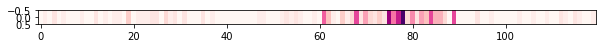

In [21]:
plt.figure(figsize=(10,0.25))

plt.imshow(da.sum('time_relative_to_stimulus_onset').T / 2, cmap='RdPu', aspect='auto')

### Extracting the population response

We can use the `presentationwise_spike_counts` method to retrieve the presentation-aligned activity for all the units in V1, just by changing the last input argument:

In [22]:
unit_ids = unit_metrics_VISp.sort_values(by=['pref_ori_dg']).index.values

da = session.presentationwise_spike_counts(np.arange(0,1.99,0.01), presentations.index.values, unit_ids)

da

<xarray.DataArray 'spike_counts' (stimulus_presentation_id: 120,
                                  time_relative_to_stimulus_onset: 198,
                                  unit_id: 94)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 1, 0],
        [1, 0, 1, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 1, ..., 1, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0]]], dtype=uint16)
Coordinates:
  * stimulus_presentation_id         (stimulus_presentation_id) int64 3918 .....
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 ...
  * unit_id                          (unit_id) int64 951103958 ... 951102411

Now, the `unit_id` dimension has 94 entries instead of one, but the other dimensions are identical.

Let's plot the normalized firing rates for all units and all presentations:

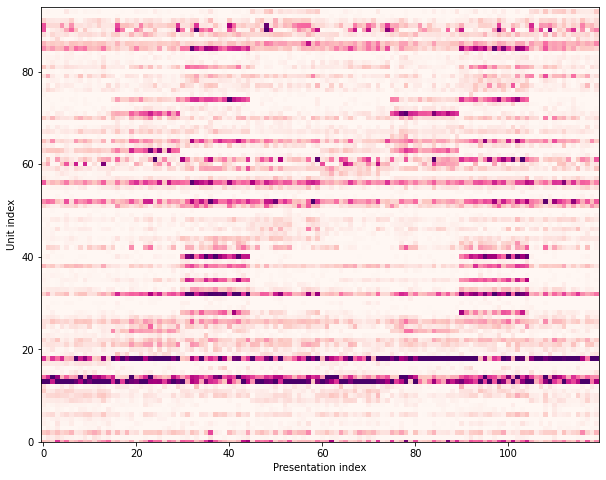

In [23]:
plt.figure(figsize=(10,8))

firing_rates = da.sum('time_relative_to_stimulus_onset').T / 2
max_rates = firing_rates.max('unit_id')
norm_firing_rates = firing_rates / np.tile(max_rates, (len(unit_ids),1))

plt.imshow(norm_firing_rates, cmap='RdPu', aspect='auto', vmax=1)
plt.xlabel('Presentation index')
plt.ylabel('Unit index')
_ = plt.ylim([0, len(unit_ids)])

There are a few things worth noting about this plot:

- Because we sorted the `presentations` table by orientation, the transitions between the orientation conditions are obvious for many units
- A large fraction of units are selective to *orientation* but not *direction*, resulting in similar firing rates for orientations separated by 180 degrees

Just from looking at this data, it seems like it will be possible to extract the stimulus orientation from the firing rates within a given trial (the columns in this matrix). We can select one of these columns using the `DataArray.sel` operator:

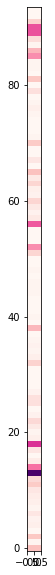

In [24]:
one_trial = norm_firing_rates.sel(stimulus_presentation_id = presentations.index.values[0])

plt.figure(figsize=(0.25,10))

plt.imshow(np.expand_dims(one_trial, axis=1), cmap='RdPu', aspect='auto', origin='lower')

This represents the normalized firing rate of all units recorded in V1 for a single trial. Let's format the data in such a way that it's possible to feed it into a `scikit-learn` classifier:

In [25]:
responses = norm_firing_rates.data.T
labels = presentations.orientation.values.astype('int')
conditions = np.unique(labels)

print(f'Shape of response matrix: {responses.shape}')
print(f'Shape of labels matrix: {labels.shape}')

Shape of response matrix: (120, 94)
Shape of labels matrix: (120,)


The `responses` matrix contains the normalized firing rates for 120 trials and 94 neurons, and the `labels` matrix contains the orientation for 120 trials. Therefore, each trial is represented as a point in a 94 dimensional space. Our goal is to try and draw boundaries in this space that can be used distinguish between the different grating orientations on randomly held out trials.

Before we train a classifer, let's see what the data looks like when we embed it within a 2-dimensional space using t-SNE:

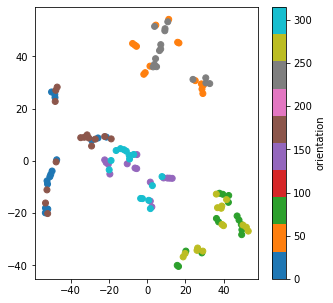

In [26]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=3).fit_transform(norm_firing_rates.T)

plt.figure(figsize=(5,5))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=labels, cmap='tab10')
plt.colorbar(label='orientation')

`X_embedded` is a 120 x 2 matrix with one 2D point for each trial. We can observe some clustering of trials by condition, indicating that it will likely be possible to train an orientation classifer using this data.

Let's start with a Support Vector Machine (SVM) classifier, which will try to draw linear boundaries between conditions in our 94-dimensional firing rate space: 

In [27]:
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

We will use the `scikit-learn.model_selection.KFold` iterator to automatically split up the data into "train" and "test" sets for 5 iterations. Note that the model is fit independently on each iteration.

In [28]:
accuracies = []
confusions = []

for train_indices, test_indices in KFold(n_splits=5, shuffle=True).split(responses):
    
    clf = svm.SVC(gamma="scale", kernel="linear")
    clf.fit(responses[train_indices], labels[train_indices])
    
    test_targets = labels[test_indices]
    test_predictions = clf.predict(responses[test_indices])
    
    accuracy = 1 - (np.count_nonzero(test_predictions - test_targets) / test_predictions.size)
    print(accuracy)
    
    accuracies.append(accuracy)
    confusions.append(confusion_matrix(y_true=test_targets, y_pred=test_predictions, labels=conditions))
    
print(f"\nmean accuracy: {np.mean(accuracies)}")
print(f"chance: {1/conditions.size}")

0.7083333333333333
0.7083333333333333
0.7916666666666666
0.6666666666666667
0.7083333333333333

mean accuracy: 0.7166666666666666
chance: 0.125


Our SVM model performs much better than chance levels, for which we'd expect a classification accuracy of 12.5%.

We can visualize its performance in more detail using a confusion metrix:

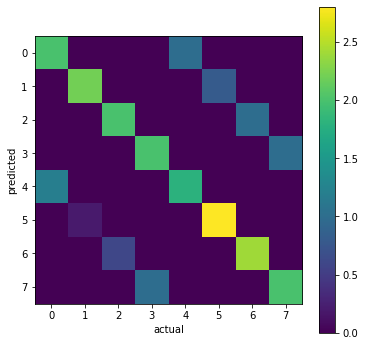

In [29]:
def plot_confusion_matrix(confusions):
    
    plt.figure(figsize=(6,6))
    
    mean_confusion = np.mean(confusions, axis=0)

    plt.imshow(mean_confusion)
    plt.colorbar()

    plt.xlabel("actual")
    plt.ylabel("predicted")
    
plot_confusion_matrix(confusions)

When the model makes mistakes, it tends to mis-classify trials by 180 degrees, which is expected given the fact that many units are selective to orientation but not direction.

To try to avoid some of these errors, we can try a nonlinear classifier (Random Forest) which uses a set of decision trees to determine the label for each trial:

In [30]:
from sklearn.ensemble import RandomForestClassifier

accuracies = []
confusions = []

for train_indices, test_indices in KFold(n_splits=5, shuffle=True).split(responses):
    
    clf = RandomForestClassifier()
    clf.fit(responses[train_indices], labels[train_indices])
    
    test_targets = labels[test_indices]
    test_predictions = clf.predict(responses[test_indices])
    
    accuracy = 1 - (np.count_nonzero(test_predictions - test_targets) / test_predictions.size)
    print(accuracy)
    
    accuracies.append(accuracy)
    confusions.append(confusion_matrix(y_true=test_targets, y_pred=test_predictions, labels=conditions))
    
print(f"\nmean accuracy: {np.mean(accuracies)}")
print(f"chance: {1/conditions.size}")

0.875
0.9166666666666666
0.875
0.875
0.7916666666666666

mean accuracy: 0.8666666666666666
chance: 0.125


This model appears to be doing even better than the SVM.

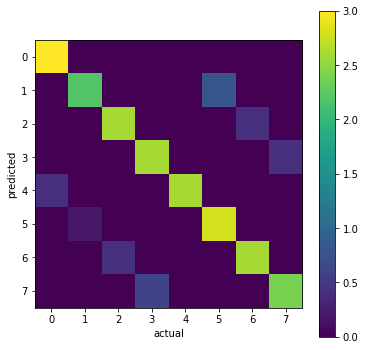

In [31]:
plot_confusion_matrix(confusions)

In this tutorial, we learned how to decode drifting grating orientations from population firing rates in V1. Using both a linear (SVM) and nonlinear (Random Forest) classifer, we were able to achieve high levels of decoding accuracy. This only scratches the surface of population-level decoding, and raises a number of follow-up questions that can be pursued as problem sets:

### Problem sets

1. How does decoding accuracy change for different stimulus types (e.g. natural scenes, static gratings)?
2. How does decoding accuracy vary across brain regions or cortical depths?
3. On average, what is the minimum number of simultaneously recorded neurons needed to achieve high decoding performance?
4. What is the minimum amount of time within a trial needed to achieve high decoding performance?
5. How does decoding performance change with behavioral state (e.g. running vs. stationary)?